In [1]:
import keras
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
import numpy as np
import os
import h5py
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.regularizers import l1
from collections import namedtuple
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam

Option = namedtuple("MyStruct", "inputModel inputFile tree config outputDir ")
options = Option(
    inputModel = 'KERAS_conv1d_weights.h5',
    inputFile = 'processed-pythia82-lhc13-all-pt1-50k-r1_h022_e0175_t220_nonu_withPars_truth.z',
    tree = 't_allpar_new',
    config = 'train_config_conv1d.yml',
    outputDir = 'output'
)

print("Loading configuration from", options.config)
config = open(options.config, 'r')
yamlConfig =  yaml.load(config, Loader = yaml.FullLoader)
yamlConfig

Using TensorFlow backend.


Loading configuration from train_config_conv1d.yml


{'Inputs': ['j1_ptrel',
  'j1_etarot',
  'j1_phirot',
  'j1_erel',
  'j1_deltaR',
  'j1_costhetarel',
  'j1_pdgid',
  'j_index'],
 'Labels': ['j_g', 'j_q', 'j_w', 'j_z', 'j_t', 'j_index'],
 'KerasModel': 'conv1d_model',
 'KerasModelRetrain': 'conv1d_model_constraint',
 'KerasLoss': 'categorical_crossentropy',
 'L1Reg': 0.0001,
 'NormalizeInputs': 1,
 'InputType': 'Conv1D',
 'MaxParticles': 100}

In [2]:
f = h5py.File(options.inputFile, 'r')
treeArray = f[options.tree][()]
#features = ['j1_ptrel','j1_etarot','j1_phirot','j1_erel','j1_deltaR','j1_costhetarel','j1_pdgid','j1_pt']
#labels = ['j_g','j_q','j_w','j_z','j_t']

features = yamlConfig['Inputs']
labels = yamlConfig['Labels']

features_df = pd.DataFrame(treeArray,columns=list(set(features)))
labels_df = pd.DataFrame(treeArray,columns=list(set(labels)))

features_labels_df = pd.DataFrame(treeArray,columns = list(set(features + labels)))
features_labels_df = features_labels_df.drop_duplicates()

features_labels_df

,j1_deltaR,j_index,j1_phirot,j_g,j_t,j1_ptrel,j1_costhetarel,j1_etarot,j1_pdgid,j_z,j_q,j_w,j1_erel
0,0.135378,300003264.0,-0.201170,0,0,0.001060,-0.068480,-0.068588,111.0,1,0,0,0.001084
1,0.321080,400010240.0,-0.348590,0,1,0.000626,-0.113337,-0.113826,111.0,0,0,0,0.000640
2,0.061471,200017616.0,0.001577,0,0,0.046280,0.003166,0.003166,111.0,0,0,1,0.045609
3,0.015611,12607.0,-0.005436,1,0,0.132881,-0.015673,-0.015675,211.0,0,0,0,0.133103
4,0.328146,400011040.0,-0.006246,0,1,0.001762,-0.336582,-0.350233,211.0,0,0,0,0.001496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5119904,0.071287,6717.0,-0.104943,1,0,0.003359,0.061860,0.061939,111.0,0,0,0,0.003480
5119905,0.243789,200000848.0,-0.271796,0,0,0.003650,0.003421,0.003421,111.0,0,0,1,0.004210
5119906,0.205047,300014656.0,-0.242324,0,0,0.022742,-0.002743,-0.002743,2212.0,1,0,0,0.022763
5119907,0.215792,9068.0,-0.163521,1,0,0.002943,-0.196689,-0.199286,111.0,0,0,0,0.003270


# conv1d model



In [3]:
MaxParticles = 100
# Convert to nparray
labels_df = labels_df.drop_duplicates()
features_val = features_df.drop(['j_index'],axis=1).values
labels_val = labels_df.drop(['j_index'],axis=1).values

#get feature
features_2dval = np.zeros((len(labels_df), MaxParticles, len(features) - 1))
for i in range(0, len(labels_df)):
    features_df_i = features_df[features_df['j_index'] == labels_df['j_index'].iloc[i]]
    index_values = features_df_i.index.values

    features_val_i = features_val[np.array(index_values), :]
    nParticles = len(features_val_i)
    features_val_i = features_val_i[features_val_i[:, 0].argsort()[::-1]]  # sort descending by first value (ptrel, usually)
    
    if nParticles > MaxParticles:
        features_val_i = features_val_i[0:MaxParticles, :]
    else:
        features_val_i = np.concatenate([features_val_i, np.zeros((MaxParticles - nParticles, len(features) - 1))])
    features_2dval[i, :, :] = features_val_i

features_val = features_2dval


In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(features_val, labels_val, test_size=0.2,random_state=42)


In [5]:
# Normalization
reshape_X_train_val = X_train_val.reshape(X_train_val.shape[0] * X_train_val.shape[1], X_train_val.shape[2])
scaler = preprocessing.StandardScaler().fit(reshape_X_train_val)
for p in range(X_train_val.shape[1]):
    X_train_val[:, p, :] = scaler.transform(X_train_val[:, p, :])
    X_test[:, p, :] = scaler.transform(X_test[:, p, :])
if 'j_index' in labels:
        labels = labels[:-1]

MODEL CONV1D

In [20]:
l1Reg = 0.0001
model = models.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(100, 7)))
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv1D(filters=32, kernel_size=40, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv1D)        (None, 100, 32)           8992      
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 50)                160050    
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 255       
Total params: 251,281
Trainable params: 251,281
Non-trainable params: 0
________________________________________________

In [21]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 20, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/20
15/15 [==============================] - 7s 478ms/step - loss: 1.0933 - accuracy: 0.8255 - val_loss: 0.7396 - val_accuracy: 0.9275
Epoch 2/20
15/15 [==============================] - 7s 478ms/step - loss: 0.6788 - accuracy: 0.9402 - val_loss: 0.6437 - val_accuracy: 0.9514
Epoch 3/20
15/15 [==============================] - 8s 510ms/step - loss: 0.6101 - accuracy: 0.9568 - val_loss: 0.6042 - val_accuracy: 0.9603
Epoch 4/20
15/15 [==============================] - 7s 481ms/step - loss: 0.5751 - accuracy: 0.9629 - val_loss: 0.5687 - val_accuracy: 0.9672
Epoch 5/20
15/15 [==============================] - 7s 458ms/step - loss: 0.5493 - accuracy: 0.9652 - val_loss: 0.5456 - val_accuracy: 0.9670
Epoch 6/20
15/15 [==============================] - 7s 469ms/step - loss: 0.5192 - accuracy: 0.9706 - val_loss: 0.5320 - val_accuracy: 0.9645
Epoch 7/20
15/15 [==============================] - 7s 462ms/step - loss: 0.5109 - accuracy: 0.9639 - val_loss: 0.5060 - val_accuracy: 0.9692
Epoch 

In [23]:
model.save('CNN1d')
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: CNN1d\assets
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv1D)        (None, 100, 32)           8992      
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 100, 32)           40992     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3200)              0         
_________________________________________________________________
fc1_relu (Dense)             (None, 50)                160050    
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 25

# Conv1d test

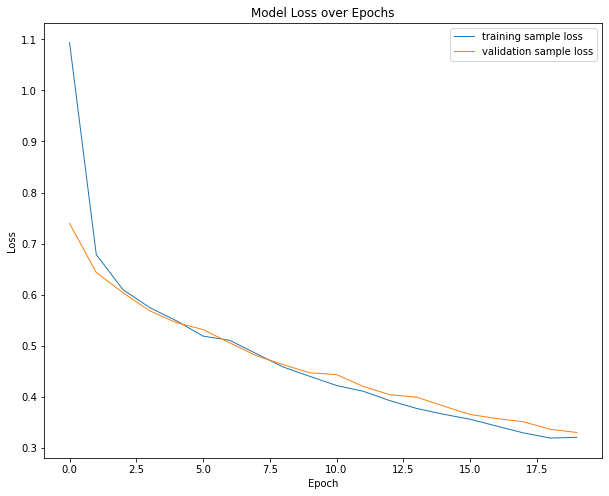

In [24]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

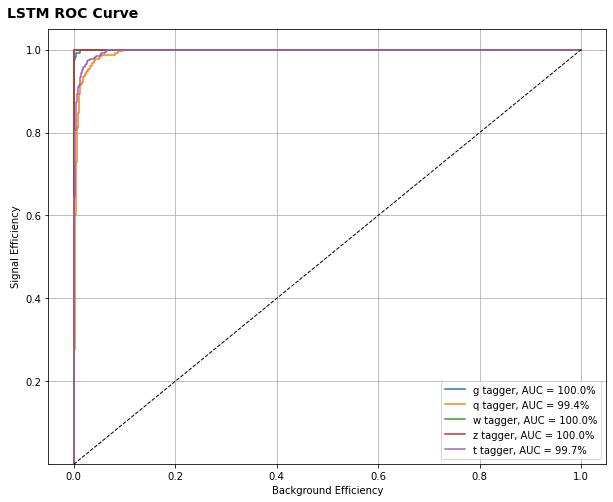

In [25]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'LSTM ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv1d')

Text(0.25, 0.9, 'Conv_1d_notebook_version')

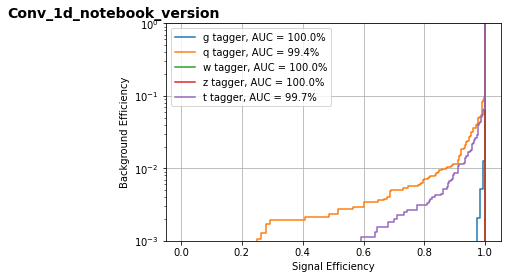

In [26]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_notebook_version',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

# Conv1d small

In [6]:
l1Reg = 0.0001
model = models.Sequential()
model.add(layers.Conv1D(filters=8, kernel_size=4, strides=1, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_1',
               activation = 'relu', kernel_regularizer=l1(l1Reg),input_shape=(100, 7)))
model.add(layers.Conv1D(filters=4, kernel_size=4, strides=2, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_2',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Conv1D(filters=2, kernel_size=4, strides=3, padding='same',
               kernel_initializer='he_normal', use_bias=True, name='conv1_relu_3',
               activation = 'relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu', kernel_initializer='lecun_uniform', 
              name='fc1_relu', kernel_regularizer=l1(l1Reg)))
model.add(layers.Dense(5, activation='softmax', kernel_initializer='lecun_uniform', 
                        name='output_softmax', kernel_regularizer=l1(l1Reg)))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_relu_1 (Conv1D)        (None, 100, 8)            232       
_________________________________________________________________
conv1_relu_2 (Conv1D)        (None, 50, 4)             132       
_________________________________________________________________
conv1_relu_3 (Conv1D)        (None, 17, 2)             34        
_________________________________________________________________
flatten (Flatten)            (None, 34)                0         
_________________________________________________________________
fc1_relu (Dense)             (None, 32)                1120      
_________________________________________________________________
output_softmax (Dense)       (None, 5)                 165       
Total params: 1,683
Trainable params: 1,683
Non-trainable params: 0
______________________________________________________

In [7]:
adam = Adam(lr = 0.0001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(X_train_val, y_train_val, batch_size = 1024, epochs = 15, 
                    validation_split = 0.25, shuffle = True, callbacks = None,
                    use_multiprocessing=True, workers=4)

Epoch 1/15
15/15 [==============================] - 1s 34ms/step - loss: 1.9566 - accuracy: 0.1343 - val_loss: 1.4521 - val_accuracy: 0.4590
Epoch 2/15
15/15 [==============================] - 0s 25ms/step - loss: 1.1906 - accuracy: 0.6927 - val_loss: 0.9152 - val_accuracy: 0.8048
Epoch 3/15
15/15 [==============================] - 0s 21ms/step - loss: 0.7873 - accuracy: 0.8023 - val_loss: 0.6733 - val_accuracy: 0.8070
Epoch 4/15
15/15 [==============================] - 0s 21ms/step - loss: 0.6123 - accuracy: 0.8031 - val_loss: 0.5423 - val_accuracy: 0.8074
Epoch 5/15
15/15 [==============================] - 0s 21ms/step - loss: 0.5082 - accuracy: 0.8050 - val_loss: 0.4748 - val_accuracy: 0.8098
Epoch 6/15
15/15 [==============================] - 0s 21ms/step - loss: 0.4565 - accuracy: 0.8097 - val_loss: 0.4401 - val_accuracy: 0.8168
Epoch 7/15
15/15 [==============================] - 0s 22ms/step - loss: 0.4279 - accuracy: 0.8163 - val_loss: 0.4194 - val_accuracy: 0.8241
Epoch 8/15
15

TEST

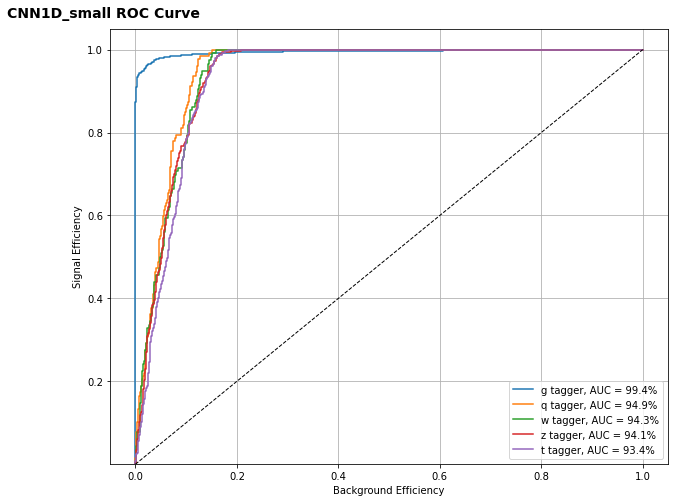

In [10]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'CNN1D_small ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

y_pred = makeRoc(X_test, y_test, labels, model, outputSuffix='conv2d')

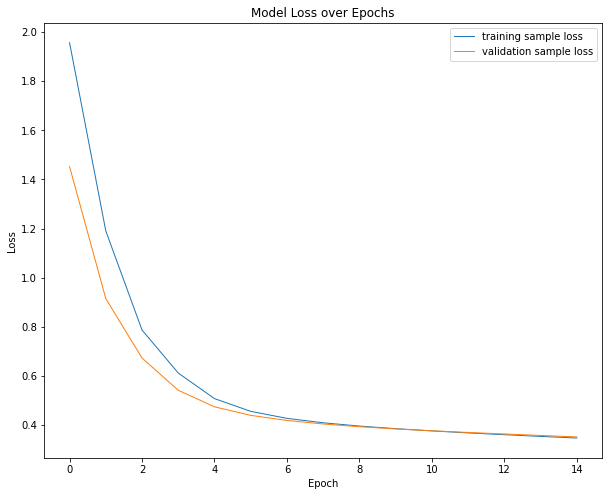

In [11]:
def learningCurve(history):
    plt.figure(figsize=(10,8))
    plt.plot(history.history['loss'], linewidth=1)
    plt.plot(history.history['val_loss'], linewidth=1)
    plt.title('Model Loss over Epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['training sample loss','validation sample loss'])
    plt.savefig('Learning_curve.pdf')
    plt.show()
    plt.close()

learningCurve(history)

Text(0.25, 0.9, 'Conv_1d_mall')

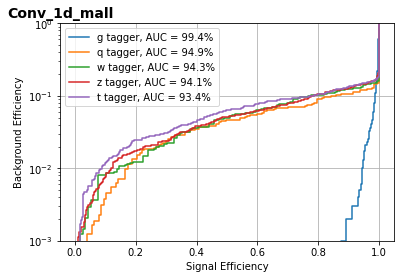

In [13]:
if 'j_index' in labels: labels.remove('j_index')

predict_test = model.predict(X_test)

df = pd.DataFrame()

fpr = {}
tpr = {}
auc1 = {}

plt.figure()       
for i, label in enumerate(labels):
    df[label] = y_test[:,i]
    df[label + '_pred'] = predict_test[:,i]

    fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

    auc1[label] = auc(fpr[label], tpr[label])

    plt.plot(tpr[label],fpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
plt.semilogy()
plt.xlabel("Signal Efficiency")
plt.ylabel("Background Efficiency")
plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.figtext(0.25, 0.90,'Conv_1d_mall',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)